# **Intallations and scanning documents**

In [ ]:

!apt install tesseract-ocr
!pip install pymupdf pytesseract opencv-python pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
!pip install jiwer python-Levenshtein

In [ ]:
!pip install python-doctr[viz]
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.11).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
!pip install python-doctr[viz]@git+https://github.com/mindee/doctr.git
!sudo apt-get install fonts-freefont-ttf -y

  Cloning https://github.com/mindee/doctr.git to /tmp/pip-install-g00f0p3z/python-doctr_b8f9a037baca43e3ac56bb96b1f69b20
  Running command git clone --filter=blob:none --quiet https://github.com/mindee/doctr.git /tmp/pip-install-g00f0p3z/python-doctr_b8f9a037baca43e3ac56bb96b1f69b20
  Resolved https://github.com/mindee/doctr.git to commit 07443a04502d3ef7bd4bf4f067305399a090fe29
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-freefont-ttf is already the newest version (20120503-10build1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


## **Reading scanned documents**

In [ ]:
import os
# Detect all jpg in /content
image_folder = "/content"
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(".jpg")]

#testing if images are loading
for image_path in image_files:
  print(image_path)


/content/94333601.jpg
/content/40035380-5380.jpg
/content/50313867-3869.jpg
/content/tnwl0049688_9693.jpg
/content/ton04200.95.jpg
/content/679995.jpg
/content/93117926_7928.jpg
/content/CTRSP-FILES027316-73.jpg
/content/tim01047.91.jpg
/content/99115867_5869.jpg
/content/50453779-3780.jpg
/content/88990360.jpg
/content/ti10691080_1083.jpg
/content/tob07526.89.jpg
/content/titx1529.40_titx1529.41.jpg
/content/99488529.jpg
/content/505889574+-9575.jpg
/content/518039321.jpg
/content/2084619272_9273.jpg
/content/50650671-0672.jpg


In [ ]:
import cv2
import pytesseract
import numpy as np
from PIL import Image
import re
import json

# **Preprocessing the document for tesseract alone**

In [ ]:
def preprocess(img):
  img_np= np.array(img)
  # Convert image to grayscale
   # Check number of channels
  if len(img_np.shape) == 3:
    # Color image: convert to grayscale
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
  else:
    # Already grayscale
      gray = img_np

  # Apply Adaptive Thresholding for contrast enhancement
  gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 5)

  # Apply Bilateral Filtering to reduce noise while preserving edges
  gray = cv2.bilateralFilter(gray, 11, 100, 100)

  kernel = np.ones((1, 1), np.uint8)
  gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)  # Remove small noise
  gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel) # Fill small gaps in letters


  # Resize image for better OCR accuracy (Tesseract performs better on larger text)
  scale_percent = 250 # Increase image size
  width = int(gray.shape[1] * scale_percent / 100)
  height = int(gray.shape[0] * scale_percent / 100)
  gray = cv2.resize(gray, (width, height), interpolation=cv2.INTER_CUBIC)

  # Show the preprocessed image for debugging
  #display(Image.fromarray(gray))
  return Image.fromarray(gray)


# **Tesseract and docTR setup**

In [ ]:
#Tesseract
def tesseract_ocr(img_path):

  img=Image.open(img_path)
  #preprocess the scanned image
  img_preprocessed=preprocess(img)

  #Use tesseract to extract text values
  custom_config = r'--oem 3 -l eng'
  ocr_data = pytesseract.image_to_data(img_preprocessed, output_type=pytesseract.Output.DICT, config=custom_config)
  ocr_text = " ".join([t.strip() for t in ocr_data["text"] if t.strip()])

  # Build list of bounding boxes
  boxes = []
  for i in range(len(ocr_data["text"])):
      word = ocr_data["text"][i].strip()
      conf = int(ocr_data["conf"][i])
      if not word or conf < 0:
          continue
      boxes.append({
            "left": ocr_data["left"][i],
            "top": ocr_data["top"][i],
            "width": ocr_data["width"][i],
            "height": ocr_data["height"][i],
            "conf": conf,
            "text": word
      })

  return {
        "text": ocr_text,
        "image_path": img_path,
        "boxes": boxes,
        "model": "tesseract",
        "preprocessed_image": img_preprocessed
    }


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

from doctr.io import DocumentFile
from doctr.models import ocr_predictor
from doctr.models import ocr_predictor
from doctr.io import DocumentFile
from PIL import Image

# Initialize docTR OCR predictor
model = ocr_predictor(pretrained=True)

In [ ]:

def docTR_processing_image(image_path: str) -> str:
    """
    Extract text from a scanned image using docTR.
    Returns the full text as a single string.
    """
    # Load image
    #img = Image.open(image_path)

    # Wrap image into docTR DocumentFile
    doc = DocumentFile.from_images(image_path)

    # Run OCR
    result = model(doc)

    # Convert result to plain text
    string_result = result.render()

    # Extract bounding boxes
    boxes = []
    for page in result.pages:
        for block in page.blocks:
            for line in block.lines:
                for word in line.words:
                    # Convert normalized coordinates [0,1] to pixel coordinates later
                    boxes.append({
                        "x_min": word.geometry[0][0],
                        "y_min": word.geometry[0][1],
                        "x_max": word.geometry[1][0],
                        "y_max": word.geometry[1][1],
                        "confidence": word.confidence,
                        "text": word.value
                    })

    return {"text":string_result,
            "model":"docTR",
            "boxes": boxes,
            "image_path":image_path}


In [ ]:
from jiwer import wer
import Levenshtein

def compute_metrics(pred_text, true_text):
    # Normalize text
    pred = pred_text.strip().lower()
    true = true_text.strip().lower()

    # Compute metrics
    wer_score = wer(true, pred)
    cer_score = Levenshtein.distance(true, pred) / max(len(true), 1)

    return {
        "WER": round(wer_score, 4),
        "CER": round(cer_score, 4)
    }

**Processing scanned docs using docTR and tesseract**

In [ ]:
import time
all_results = []
for image_path in image_files:
  #print(image_path)
  gt_path = os.path.join(image_folder, image_path.replace(".jpg", "_GT.txt"))

  if not os.path.exists(gt_path):
      print(f"⚠️ Ground truth not found for {image_path}")
      continue

  start = time.time()
  tesseract_result = tesseract_ocr(image_path)
  end = time.time()
  tesseract_result["time"] = end - start
  # Load ground truth
  with open(gt_path, "r") as f:
        gt_text = f.read()


  # get metrics for tesseract
  tesseract_result['metrics']=compute_metrics(tesseract_result["text"], gt_text)
  print(tesseract_result)

  start = time.time()
  docTR_result=docTR_processing_image(image_path)
  end = time.time()
  docTR_result["time"] = end - start

  # get metrics for docTR
  docTR_result['metrics']=compute_metrics(docTR_result["text"], gt_text)
  print(docTR_result)


  all_results.append({
        "image": image_path,
        "tesseract": tesseract_result,
        "docTR": docTR_result
    })







{'text': "aed he oe ef 2. - &. atte NR adams ROL Laie hewn pg x, dt es a tems aan O2aaO eg ° ono ” met whole dollars for 40 _4t : Atocated sveetrant econ ufipy tine: 18 by Allocated business income , (multiply tine 19 by - Roal proporty and niKetAe li | ) Investment ccphe! (from CT-3-ATT, fine 113, column 8. A ral 8 Business Corporation “ae | ' Franehis se Tax Return | For otficouse only ‘You rust roport ‘changos ta your }] Aamo, EIn, address or | ovmcr/atficcr || information on Form OTF+83. Alco, if | addross on rotumn inl - ig now, 6 Ox: |{ Oato rocvived | |. soveciation or publicly trodod ¥paricrab, 0 chock B ae tee 1 ni. 8. S69 © ce 6 le 8 ce ote oe ese 8 wl ke ke et Fe ee SS o @ © @ 6: te el ew ee Oe: 9 i Hee ‘Otee subtrections (aticch | Bet- ~ 969 ntructone) o ete ee ere _ . 16 Total subtractions (add fines 10 through 15)... . RB WAVE Diasec eee e emt urns ec [IO f 17 Entire net incoms (subtréct fine 16 from lina 9). fee ® wal | investrient incom: for atocation Cron ¢ GT “3-ATT i

# **Metrics for evaluation**

In [ ]:
import pandas as pd
n = len(all_results)
avg_wer_tesseract = sum(r["tesseract"]["metrics"]["WER"] for r in all_results) / n
avg_cer_tesseract = sum(r["tesseract"]["metrics"]["CER"] for r in all_results) / n
avg_time_tesseract = sum(r["tesseract"]["time"] for r in all_results) / n

avg_wer_docTR = sum(r["docTR"]["metrics"]["WER"] for r in all_results) / n
avg_cer_docTR = sum(r["docTR"]["metrics"]["CER"] for r in all_results) / n
avg_time_docTR = sum(r["docTR"]["time"] for r in all_results) / n

# Compute averages
avg_results = {
    "OCR Engine": ["Tesseract", "docTR"],
    "Average WER": [avg_wer_tesseract, avg_wer_docTR],
    "Average CER": [avg_cer_tesseract, avg_cer_docTR],
    "Average Runtime (s)": [avg_time_tesseract, avg_time_docTR]
}

# Convert to DataFrame for nice table
df_avg = pd.DataFrame(avg_results)
print(df_avg)


  OCR Engine  Average WER  Average CER  Average Runtime (s)
0  Tesseract     0.948625     0.444775            11.911349
1      docTR     0.486915     0.269280            13.378083


In [ ]:
# Worst and best documents for Tesseract based on WER
tess_worst = max(all_results, key=lambda r: r["tesseract"]["metrics"]["WER"])
tess_best = min(all_results, key=lambda r: r["tesseract"]["metrics"]["WER"])

# Worst and best documents for docTR based on WER
doctr_worst = max(all_results, key=lambda r: r["docTR"]["metrics"]["WER"])
doctr_best = min(all_results, key=lambda r: r["docTR"]["metrics"]["WER"])

# Print results
print("Tesseract Worst (WER):", tess_worst["image"], tess_worst["tesseract"]["metrics"]["WER"])
print("Tesseract Best (WER):", tess_best["image"], tess_best["tesseract"]["metrics"]["WER"])

print("docTR Worst (WER):", doctr_worst["image"], doctr_worst["docTR"]["metrics"]["WER"])
print("docTR Best (WER):", doctr_best["image"], doctr_best["docTR"]["metrics"]["WER"])


Tesseract Worst (WER): /content/518039321.jpg 1.5765
Tesseract Best (WER): /content/ton04200.95.jpg 0.4398
docTR Worst (WER): /content/505889574+-9575.jpg 0.8966
docTR Best (WER): /content/titx1529.40_titx1529.41.jpg 0.1818


In [ ]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def draw_boxes_on_image(image_path, boxes, color=(0,255,0), title="", normalized=False):
    """Draw bounding boxes (handles both normalized and absolute)."""
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    for box in boxes:
        # Handle docTR or Tesseract format
        if "x_min" in box:  # docTR
            if normalized:  # docTR coords are normalized
                x_min = int(box["x_min"] * w)
                y_min = int(box["y_min"] * h)
                x_max = int(box["x_max"] * w)
                y_max = int(box["y_max"] * h)
            else:  # sometimes docTR outputs absolute coords already
                x_min, y_min, x_max, y_max = int(box["x_min"]), int(box["y_min"]), int(box["x_max"]), int(box["y_max"])
        else:  # Tesseract
            x_min = int(box["left"])
            y_min = int(box["top"])
            x_max = x_min + int(box["width"])
            y_max = y_min + int(box["height"])

        # Draw box + text
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
        text = box.get("text", "")
        if text:
            cv2.putText(img, text[:10], (x_min, max(10, y_min - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv2.LINE_AA)

    plt.imshow(img)
    plt.axis("off")
    plt.title(title)


# **docTR's best and worst processing**


*   significant accuracy than Tesseract
*   Tesseract images have been preprocessed before inputting to model



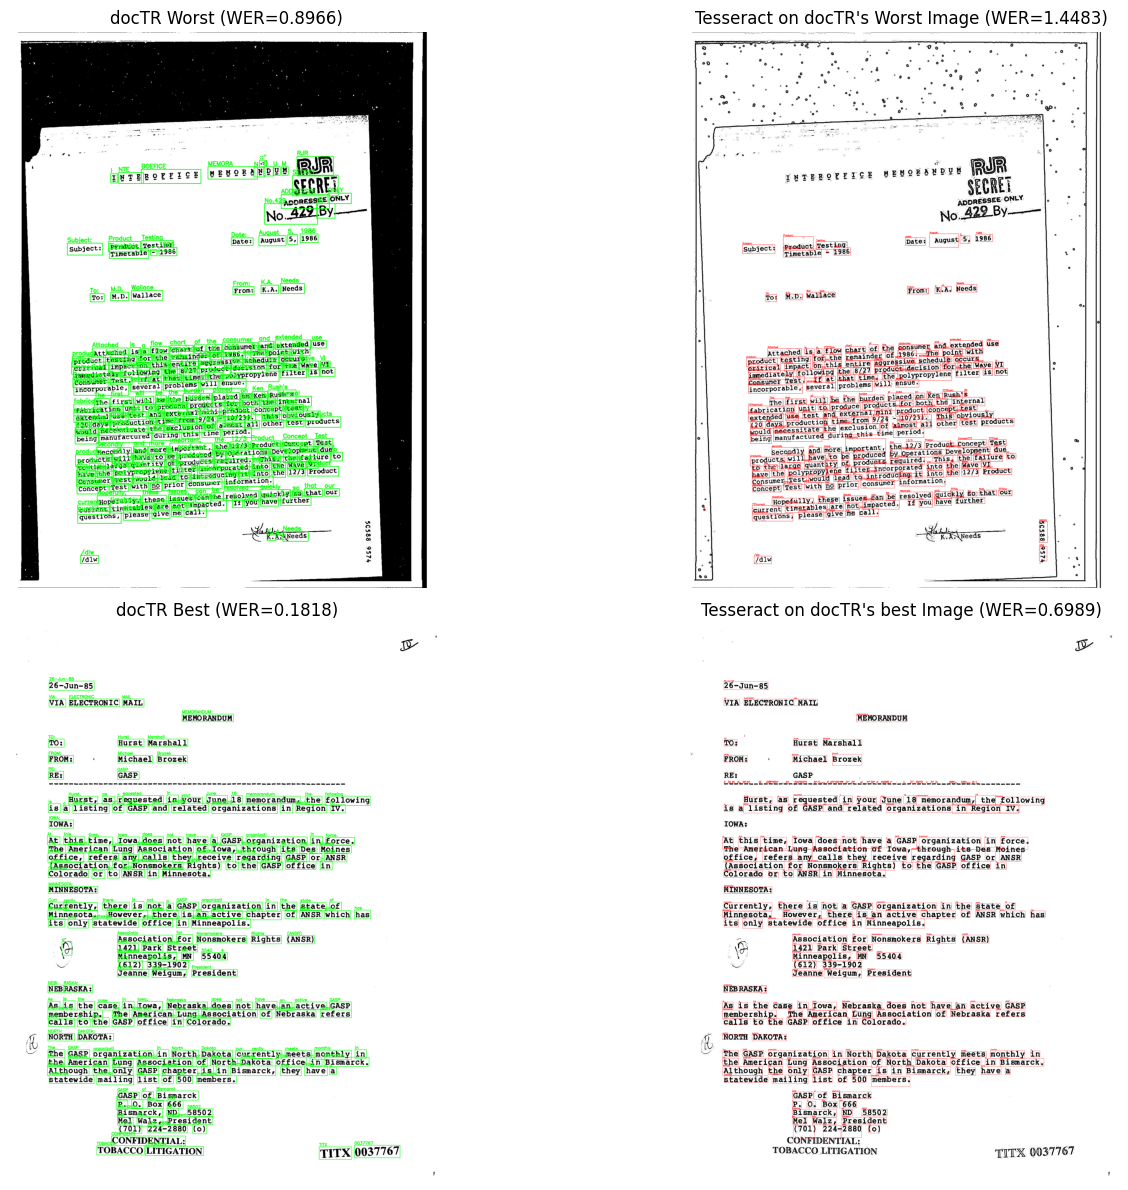

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Worst comparison
plt.subplot(2,2,1)
draw_boxes_on_image(doctr_worst["image"], doctr_worst["docTR"]["boxes"],
                    color=(0,255,0), title="docTR Worst (WER=0.8966)", normalized=True)

plt.subplot(2,2,2)
img_preprocessed01=next(r for r in all_results if r["image"] == doctr_worst["image"])["tesseract"]["preprocessed_image"]
img_preprocessed01.save("preprocessed01.png")
tesseract_on_docTR_worst_WER=next(r for r in all_results if r["image"] == doctr_worst["image"])["tesseract"]["metrics"]["WER"]
# draw_boxes_on_image(next(r for r in all_results if r["image"] == doctr_worst["image"])["tesseract"]["image_path"],
#                     next(r for r in all_results if r["image"] == doctr_worst["image"])["tesseract"]["boxes"],
#                     color=(255,0,0), title=f"Tesseract on docTR's Worst Image (WER={tesseract_on_docTR_worst_WER:.4f})", normalized=False)
draw_boxes_on_image("preprocessed01.png",
                    next(r for r in all_results if r["image"] == doctr_worst["image"])["tesseract"]["boxes"],
                    color=(255,0,0), title=f"Tesseract on docTR's Worst Image (WER={tesseract_on_docTR_worst_WER:.4f})", normalized=False)



# Best comparison
plt.subplot(2,2,3)
draw_boxes_on_image(doctr_best["image"], doctr_best["docTR"]["boxes"],
                    color=(0,255,0), title="docTR Best (WER=0.1818)", normalized=True)

plt.subplot(2,2,4)
img_preprocessed02=next(r for r in all_results if r["image"] == doctr_best["image"])["tesseract"]["preprocessed_image"]
img_preprocessed02.save("preprocessed02.png")
tesseract_on_docTR_best_WER=next(r for r in all_results if r["image"] == doctr_best["image"])["tesseract"]["metrics"]["WER"]
draw_boxes_on_image("preprocessed02.png",
                    next(r for r in all_results if r["image"] == doctr_best["image"])["tesseract"]["boxes"],
                    color=(255,0,0), title=f"Tesseract on docTR's best Image (WER={tesseract_on_docTR_best_WER:.4f})", normalized=False)

plt.tight_layout()
plt.show()


from jiwer import wer
import Levenshtein

def compute_metrics(pred_text, true_text):
    # Normalize text
    pred = pred_text.strip().lower()
    true = true_text.strip().lower()

    # Compute metrics
    wer_score = wer(true, pred)
    cer_score = Levenshtein.distance(true, pred) / max(len(true), 1)

    return {
        "WER": round(wer_score, 4),
        "CER": round(cer_score, 4)
    }